# Simple linear regression example

Performing a simple linear regression in Jags is surprisingly easy. Additionally, once we have understood how this works, it is very easy to progess to more complex models, such as generalized linear models.

First, we'll set up simulated data from a linear model:

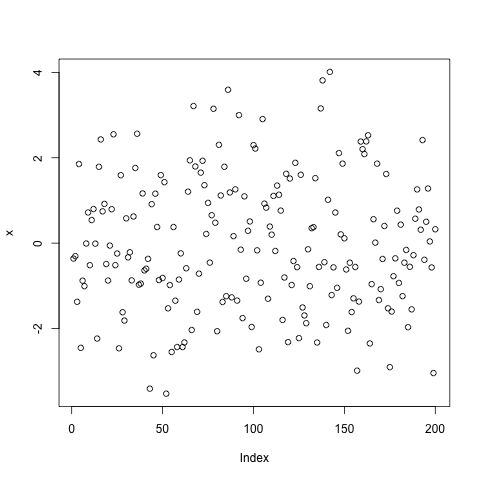

In [38]:
N <- 1000 # number of observations

# x <- seq(from = -2, to = 2, length.out = N) # predictor variable

x <- rnorm(200, 0, 1.5) # predictor variable
plot(x)

In [33]:
a <- -1 # intercept
b <- 0.8 # slope

sigma <- 1.2 #sampling noise

In [34]:
y_hat <- a + b*x # linear predictor

y <- rnorm(N, y_hat, sigma)  # response variable

Before, we begin, it'a always a good idea to have a look at the data:

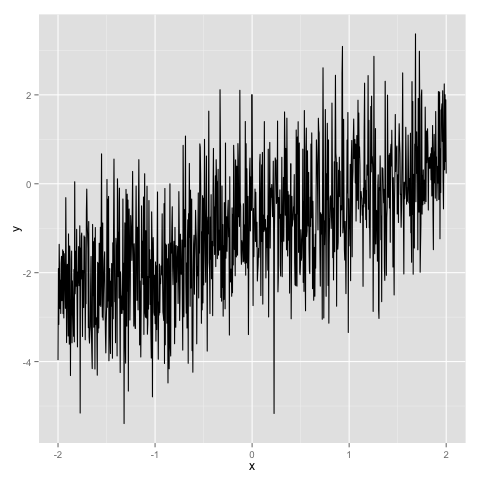

In [21]:
library(ggplot2)
qplot(x, y, geom = "line")

Next, we write the model specification in Jags. As before, you should save this in a text file, naming it "lin_reg.bug" or similar.

The part you actually want to save is this:

``` R
model {
    for (i in 1:N){
        y[i] ~ dnorm(y.hat[i], tau)
        y.hat[i] <- a + b * x[i]
    }
    a ~ dnorm(0, .0001)
    b ~ dnorm(0, .0001)
    tau <- pow(sigma, -2)
    sigma ~ dunif(0, 100)
}
```

In [22]:
modelstr <- "
model {
    for (i in 1:N){
        y[i] ~ dnorm(y_hat[i], tau)
        y_hat[i] <- a + b * x[i]
    }
    
    # priors on the coefficients
    a ~ dnorm(0, 1e-03)
    b ~ dnorm(0, 1e-03)

    # prior residual standard deviation
    tau <- pow(sigma, -2)
    sigma ~ dunif(0, 100)
}"

Next, we'll load the `R2jags` package.

In [23]:
library(R2jags)

Specify the data:

In [24]:
jagsdata <- list(y = y,
                 x = x,
                 N = length(y))

And the intial values:

In [25]:
inits <- function() {
    list(a = rnorm(1, 0, 10),
         b = rnorm(1, 0, 10),
         sigma = runif(1, 0, 100))
    }

Specify the parameters of interest:

In [26]:
parameters = c("a", "b", "sigma")

In [27]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 2,
             n.iter = 2000, n.thin = 2,n.burnin = 100,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 4010

Initializing model



In [28]:
print(fit)

Inference for Bugs model at "7", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
          mu.vect sd.vect     2.5%      25%      50%      75%    97.5%  Rhat
a          -1.030   0.036   -1.098   -1.054   -1.030   -1.005   -0.959 1.003
b           0.769   0.032    0.709    0.747    0.768    0.790    0.833 1.001
sigma       1.172   0.027    1.123    1.154    1.172    1.190    1.226 1.001
deviance 3155.403   2.421 3152.696 3153.628 3154.772 3156.498 3161.697 1.000
         n.eff
a          540
b         1900
sigma     1900
deviance  1900

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 2.9 and DIC = 3158.3
DIC is an estimate of expected predictive error (lower deviance is better).


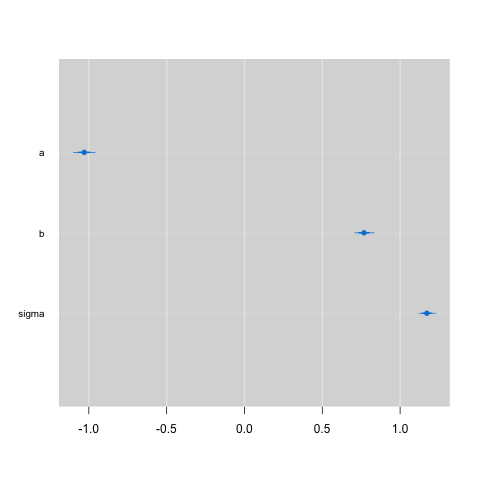

In [29]:
library(mcmcplots)
caterplot(fit, parms = c("a", "b", "sigma"))

## Exercise

1) Check to model for convergence.

2) Are you happy with the recovered parameters? Are they close enough to the true parameters?

## Advanced exercises

1) Can you create a dataset that cannot be recovered so well? 
2) How you you model this dataset?
    - Hint: `y <- rt(N, ncp = y_hat, df = 50)`

2) Try the above example, but use the following as a response variable:

In [30]:
set.seed(3425)

N <- 1000 # number of observations

x <- seq(from = -2, to = 2, length.out = N) # predictor variable

a <- -1 # intercept
b <- 0.8 # slope

z_hat <- plogis(a + b*x) # linear predictor on the logit scale

z <- rbinom(N, prob = z_hat, size = 1)  # response variable

How would you model the data now? 

> Hint: we used the inverse logistic function, `plogis()` in R, also known as a sigmoidal function, to transfotrm the linear predictor to a number between 0 and 1.

We merely need to reverse this mapping in Jags...

### Possible solution:

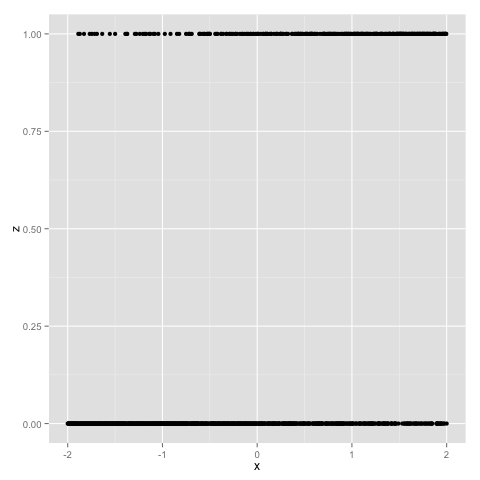

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 5005

Initializing model

Inference for Bugs model at "8", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
          mu.vect sd.vect     2.5%      25%      50%      75%    97.5%  Rhat
a          -0.983   0.376   -1.145   -1.047   -0.996   -0.939   -0.836 1.275
b           0.861   0.204    0.711    0.805    0.855    0.904    0.999 1.053
deviance 1077.334 369.699 1064.330 1064.860 1065.663 1066.989 1072.350 1.287
         n.eff
a         1900
b          370
deviance   950

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 68317.2 and DIC = 69394.6
DIC is an estimate of expected predictive error (lower deviance is better).


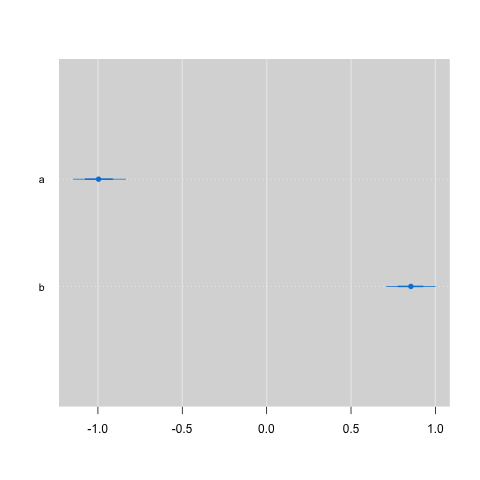

In [31]:
library(ggplot2)
qplot(x, z, geom = "point")

modelstr <- "
model {
  for (i in 1:N){
    z[i] ~ dbern(z_hat[i])
    logit(z_hat[i]) <- a + b * x[i]
}

  # priors on the coefficients
  a ~ dnorm(0, 1e-03)
  b ~ dnorm(0, 1e-03)
}"

library(R2jags)

jagsdata <- list(z = z,
                 x = x,
                 N = length(z))

inits <- function() {
    list(a = rnorm(1, 0, 10),
         b = rnorm(1, 0, 10))
}

parameters = c("a", "b")

fit <- jags(data = jagsdata, model.file = textConnection(modelstr),
            inits = inits, n.chains = 2,
            n.iter = 2000, n.thin = 2,n.burnin = 100,
            parameters.to.save = parameters)

print(fit)

library(mcmcplots)
caterplot(fit, parms = c("a", "b"))

Congratulations, you have just learned how to do a Bayesian logistic regression!